In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn import datasets
from tensorflow.python.framework import ops
import tensorflow as tf
import math
%matplotlib inline

/home/mrigank/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/mrigank/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/mrigank/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/mrigank/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework

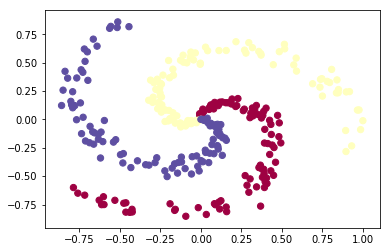

In [2]:
N = 100 
D = 2 
K = 3 
X = np.zeros((N*K,D)) 
y = np.zeros(N*K, dtype='uint8') 
for j in range(K):
    ix = range(N*j,N*(j+1))
    r = np.linspace(0.0,1,N) 
    t = np.linspace(j*4,(j+1)*4,N) + np.random.randn(N)*0.2 
    X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
    y[ix] = j
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.show()

In [3]:
print(X.shape)
print(y.shape)

(300, 2)
(300,)


In [4]:
x=X.reshape(X.shape[0],-1).T

In [5]:
print(x.shape)
print(y.shape)

(2, 300)
(300,)


In [6]:
n_values=np.max(y)+1
y=np.eye(n_values)[y]

In [7]:
y=y.reshape(y.shape[0],-1).T
print(y.shape)

(3, 300)


In [8]:
def create_placeholder(n_x,n_y):
    x=tf.placeholder(tf.float32,shape=[n_x,None],name='x')
    y=tf.placeholder(tf.float32,shape=[n_y,None],name='y')
    return x,y

In [9]:
def initialize_parameters():
    W1=tf.get_variable('W1',shape=[100,2],initializer=tf.contrib.layers.xavier_initializer(seed=1))
    b1=tf.get_variable('b1',shape=[100,1],initializer=tf.zeros_initializer())
    W2=tf.get_variable('W2',shape=[3,100],initializer=tf.contrib.layers.xavier_initializer(seed=1))
    b2=tf.get_variable('b2',shape=[3,1],initializer=tf.zeros_initializer())
    parameters={'W1':W1,'b1':b1,'W2':W2,'b2':b2}
    return parameters

In [10]:
def forward_propagation(x,parameters):
    W1=parameters['W1']
    b1=parameters['b1']
    W2=parameters['W2']
    b2=parameters['b2']
    Z1=tf.add(tf.matmul(W1,x),b1)
    A1=tf.nn.relu(Z1)
    Z2=tf.add(tf.matmul(W2,A1),b2)
    A2=tf.nn.softmax(Z2,axis=1)
    return A2

In [11]:
def compute_cost(A2,Y):
    logits=tf.transpose(A2)
    labels=tf.transpose(Y)
    cost=tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits,labels=labels))
    return cost

In [12]:
def random_mini_batches(X, Y, mini_batch_size = 64, seed = 0):
    m = X.shape[1]          
    mini_batches = []
    np.random.seed(seed)
    permutation = list(np.random.permutation(m))
    shuffled_X = X[:, permutation]
    shuffled_Y = Y[:, permutation].reshape((Y.shape[0],m))
    num_complete_minibatches = math.floor(m/mini_batch_size)
    for k in range(0, num_complete_minibatches):
        mini_batch_X = shuffled_X[:, k * mini_batch_size : k * mini_batch_size + mini_batch_size]
        mini_batch_Y = shuffled_Y[:, k * mini_batch_size : k * mini_batch_size + mini_batch_size]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    if m % mini_batch_size != 0:
        mini_batch_X = shuffled_X[:, num_complete_minibatches * mini_batch_size : m]
        mini_batch_Y = shuffled_Y[:, num_complete_minibatches * mini_batch_size : m]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    return mini_batches

In [13]:
def model(x_train,y_train,learning_rate,num_epochs,mini_batch_size=32):
    ops.reset_default_graph()           
    tf.set_random_seed(1)                             
    seed = 3                 
    (n_x,m)=x_train.shape
    (n_y)=y_train.shape[0]
    costs=[]
    x,y=create_placeholder(n_x,n_y)
    parameters=initialize_parameters()
    A2=forward_propagation(x,parameters)
    cost=compute_cost(A2,y)
    optimizer=tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)
    init=tf.global_variables_initializer()
    with tf.Session() as sess:
        sess.run(init)
        for epoch in range(num_epochs):
            epoch_cost=0
            num_minibatches=int(m/mini_batch_size)
            seed=seed+1
            minibatches=random_mini_batches(x_train,y_train,mini_batch_size,seed)
            for mini_batch in minibatches:
                (minibatch_x,minibatch_y)=mini_batch
                _,minibatch_cost=sess.run([optimizer,cost],feed_dict={x:minibatch_x,y:minibatch_y})
                epoch_cost += minibatch_cost / num_minibatches
                if epoch % 1000 == 0:
                    print ("Cost after epoch %i: %f" % (epoch, epoch_cost))
                if epoch % 20 == 0:
                    costs.append(epoch_cost)
        parameters=sess.run(parameters)
        print("Parameters have been trained")
        correct_prediction = tf.equal(tf.argmax(A2), tf.argmax(y))
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
        print ("Train Accuracy:", accuracy.eval({x: x_train, y: y_train}))
        return parameters

In [14]:
parameters=model(x,y,learning_rate=0.01,num_epochs=5000)

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See @{tf.nn.softmax_cross_entropy_with_logits_v2}.

Cost after epoch 0: 0.122059
Cost after epoch 0: 0.243979
Cost after epoch 0: 0.365790
Cost after epoch 0: 0.487496
Cost after epoch 0: 0.609084
Cost after epoch 0: 0.730482
Cost after epoch 0: 0.851873
Cost after epoch 0: 0.972828
Cost after epoch 0: 1.093766
Cost after epoch 0: 1.212249
Cost after epoch 1000: 0.115284
Cost after epoch 1000: 0.230557
Cost after epoch 1000: 0.345828
Cost after epoch 1000: 0.461108
Cost after epoch 1000: 0.576381
Cost after epoch 1000: 0.691691
Cost after epoch 1000: 0.806965
Cost after epoch 1000: 0.922225
Cost after epoch 1000: 1.037480
Cost after epoch 1000: 1.142187
Cost after epoch 2000: 0.115268
Cost after epoch 2000: 0.230535
Cost after epoch 2000: 0.345794
Cost after epoch 2000: 0.461110
Cost after epoch 2000: 0.576404
Cost after epoch 2000: 0.691690
Cost a

In [18]:
def predict(X, parameters):
    W1 = tf.convert_to_tensor(parameters["W1"])
    b1 = tf.convert_to_tensor(parameters["b1"])
    W2 = tf.convert_to_tensor(parameters["W2"])
    b2 = tf.convert_to_tensor(parameters["b2"])
    params = {"W1": W1,
              "b1": b1,
              "W2": W2,
              "b2": b2}
    x = tf.placeholder("float", [2, None])
    A2 = forward_propagation(x, params)
    p = tf.argmax(A2)
    with tf.Session() as sess:
        prediction = sess.run(p, feed_dict = {x: X})  
    return prediction

In [19]:
y_predict=predict(x,parameters)

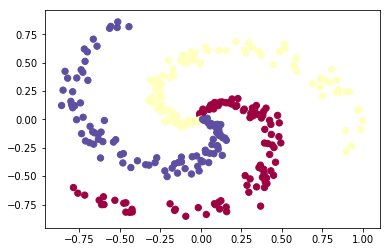

In [21]:
plt.scatter(X[:, 0], X[:, 1], c=y_predict, s=40, cmap=plt.cm.Spectral)
plt.show()

In [ ]:
Graph is al